# ASM-VFM Residuals

Import Python packages

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from viresclient import SwarmRequest

pd.plotting.register_matplotlib_converters()

Prepare the request providing:
- VirES server URL and user account information
- Swarm product type
- Measurements to be retrieved and sampling period

In [2]:
# Default parameter are read from the viresclient configuration file
req = SwarmRequest()

In [3]:
# S/C A low-rate magnetic data
req.set_collection('SW_OPER_MAGA_LR_1B')
# Measurements to be downloaded and sampling step
req.set_products(measurements=['F', 'B_VFM', 'dB_Sun'])

Get data from VirES server providing start and stop date.

In [4]:
data = req.get_between(datetime(2019, 7, 1), datetime(2019, 7, 8))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (53.834MB)


Convert returned data as xarray `Dataset` (see http://xarray.pydata.org/en/stable/)

In [5]:
xr = data.as_xarray()

xr

<xarray.Dataset>
Dimensions:     (B_VFM_dim1: 3, Timestamp: 604800, dB_Sun_dim1: 3)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2019-07-01 ... 2019-07-07T23:59:59
Dimensions without coordinates: B_VFM_dim1, dB_Sun_dim1
Data variables:
    Spacecraft  (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude    (Timestamp) float64 49.88 49.94 50.01 ... 48.93 48.99 49.06
    Longitude   (Timestamp) float64 -16.63 -16.63 -16.63 ... -26.18 -26.17
    Radius      (Timestamp) float64 6.807e+06 6.807e+06 ... 6.807e+06 6.807e+06
    F           (Timestamp) float64 3.97e+04 3.972e+04 ... 3.971e+04 3.973e+04
    B_VFM       (Timestamp, B_VFM_dim1) float64 3.894e+04 ... -8.186e+03
    dB_Sun      (Timestamp, dB_Sun_dim1) float64 0.381 -1.344 ... -1.793 0.488
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20190701T000000_20190701T235959_050...
    MagneticModels:  []
    RangeFilters:    []

Calculate the corrected and uncorrected residuals:
- corrected: $|\mathbf{B}_{VFM}| - F$
- uncorrected (adding $\mathbf{dB}_{SUN}$ disturbance): $|\mathbf{B}_{VFM} + \mathbf{dB}_{SUN}| - F$

In [6]:
B_VFM = xr['B_VFM'].values
F = xr['F'].values
dB_Sun = xr['dB_Sun'].values
t = xr['Timestamp'].values

corrected = np.linalg.norm(B_VFM, axis=1) - F
uncorrected = np.linalg.norm(B_VFM + dB_Sun, axis=1) - F

Plot the results.

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


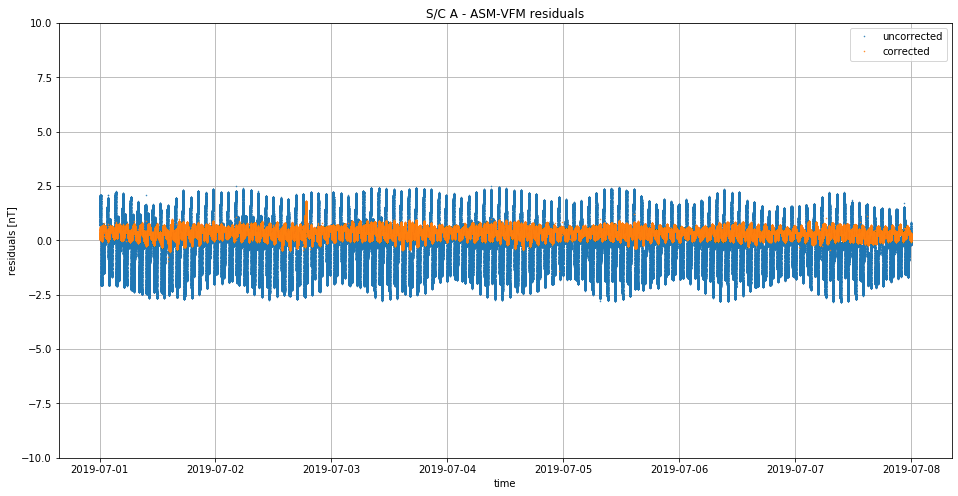

In [7]:
plt.figure(figsize=(16, 8))

plt.plot(t, uncorrected, '.', markersize='1')
plt.plot(t, corrected, '.', markersize='1')
plt.grid(True)
plt.ylabel('residuals [nT]')
plt.xlabel('time')
plt.ylim([-10, 10])
plt.legend(['uncorrected', 'corrected'])
plt.title('S/C A - ASM-VFM residuals')

plt.show()

Write result to CSV file

In [8]:
df = pd.DataFrame(
    {
        'Latitude': xr['Latitude'],
        'Longitude': xr['Longitude'],
        'Radius': xr['Radius'],
        'Corrected': corrected,
        'Uncorrected': uncorrected
    },
    index=xr['Timestamp'].values
)

df.head()

,Latitude,Longitude,Radius,Corrected,Uncorrected
2019-07-01 00:00:00,49.880565,-16.633198,6806681.67,0.286342,0.659525
2019-07-01 00:00:01,49.944819,-16.630192,6806671.59,0.316585,0.694030
2019-07-01 00:00:02,50.009074,-16.627167,6806661.53,0.311450,0.693141
2019-07-01 00:00:03,50.073328,-16.624123,6806651.48,0.320522,0.706486
2019-07-01 00:00:04,50.137581,-16.621059,6806641.44,0.299108,0.689424


In [9]:
df.to_csv('residuals.csv', index_label='Timestamp', date_format='%Y-%m-%dT%H:%M:%SZ')

Upload CSV file

In [10]:
from viresclient import ClientConfig, DataUpload

In [11]:
cc = ClientConfig()
du = DataUpload(cc.default_url, cc.get_site_config(cc.default_url)['token'])
du.clear()

In [12]:
info = du.post('residuals.csv')

In [13]:
print(info)

{'content_type': 'text/csv', 'owner': 'lmar76', 'size': 60417483, 'info': {'Uncorrected': {'shape': [604800], 'cdf_type': 45}, 'Timestamp': {'shape': [604800], 'cdf_type': 31}, 'Corrected': {'shape': [604800], 'cdf_type': 45}, 'Longitude': {'shape': [604800], 'cdf_type': 45}, 'Radius': {'shape': [604800], 'cdf_type': 45}, 'Latitude': {'shape': [604800], 'cdf_type': 45}}, 'end': '2019-07-07T23:59:59Z', 'created': '2019-11-04T15:10:36.988431Z', 'data_file': 'residuals.csv.cdf', 'checksum': '1f0a3e42e4b6e26b5a142de6d2affcf7', 'filename': 'residuals.csv', 'start': '2019-07-01T00:00:00Z', 'identifier': 'e9764f42-88df-4fae-bc23-8023d854af27'}
